In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img


In [ ]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 10

In [ ]:
image_folder = '/content/drive/MyDrive/customimages'
mask_folder = '/content/drive/MyDrive/custommasks'


In [ ]:
# Load your pre-trained models
unet_model = load_model('/content/drive/MyDrive/unetfinal_newcustom.h5')
segnet_model = load_model('/content/drive/MyDrive/segnet_newcustom.h5')
dlv3_model = load_model('/content/drive/MyDrive/deeplabv3plus_newcustom.h5')


In [ ]:
# Create an ensemble model
models = [unet_model, segnet_model, dlv3_model]
model_input = Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model1 = Model(inputs=model_input, outputs=ensemble_output, name='ensemble1')


In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_folder, batch_size, target_size):
        self.image_filenames = image_filenames
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))


    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Construct mask filenames based on image filenames
        batch_y = ['pp_' + os.path.basename(file_name)[:-4] + '_mask.jpg' for file_name in batch_x]
        batch_y = [os.path.join(self.mask_folder, mask_name) for mask_name in batch_y]

        return np.array([
            img_to_array(load_img(file_name, target_size=self.target_size)) for file_name in batch_x])/255., np.array([
            img_to_array(load_img(mask_file, color_mode="grayscale", target_size=self.target_size)) for mask_file in batch_y])/255.
    def get_all_labels(self):
        all_labels = []
        for i in range(self.__len__()):
            _, labels = self.__getitem__(i)
            for label in labels:
                all_labels.append(label)
        return np.array(all_labels)



In [ ]:
# Prepare file names for the generator
image_filenames = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]
mask_filenames = [os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder)]


In [ ]:
train_images, val_images, train_masks, val_masks = train_test_split(image_filenames, mask_filenames, test_size=0.1, random_state=42)


In [ ]:
ensemble_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Consider using a segmentation-specific metric
ensemble_history = ensemble_model.fit(train_gen, epochs=10, validation_data=val_gen)


In [ ]:
ensemble_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Consider using a segmentation-specific metric



In [ ]:
ensemble_history1 = ensemble_model1.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
156/156 [==============================] - 791s 4s/step - loss: 0.2552 - accuracy: 0.8045 - val_loss: 0.4801 - val_accuracy: 0.7695
Epoch 2/10
156/156 [==============================] - 161s 1s/step - loss: 0.2402 - accuracy: 0.8077 - val_loss: 0.4864 - val_accuracy: 0.7695
Epoch 3/10
156/156 [==============================] - 160s 1s/step - loss: 0.2327 - accuracy: 0.8082 - val_loss: 0.4611 - val_accuracy: 0.7695
Epoch 4/10
156/156 [==============================] - 160s 1s/step - loss: 0.2278 - accuracy: 0.8077 - val_loss: 0.4340 - val_accuracy: 0.7695
Epoch 5/10
156/156 [==============================] - 160s 1s/step - loss: 0.2189 - accuracy: 0.8099 - val_loss: 0.3057 - val_accuracy: 0.7727
Epoch 6/10
156/156 [==============================] - 161s 1s/step - loss: 0.2173 - accuracy: 0.8095 - val_loss: 0.2534 - val_accuracy: 0.7983
Epoch 7/10
156/156 [==============================] - 160s 1s/step - loss: 0.2135 - accuracy: 0.8103 - val_loss: 0.2602 - val_accuracy: 0.8051

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 60ms/step


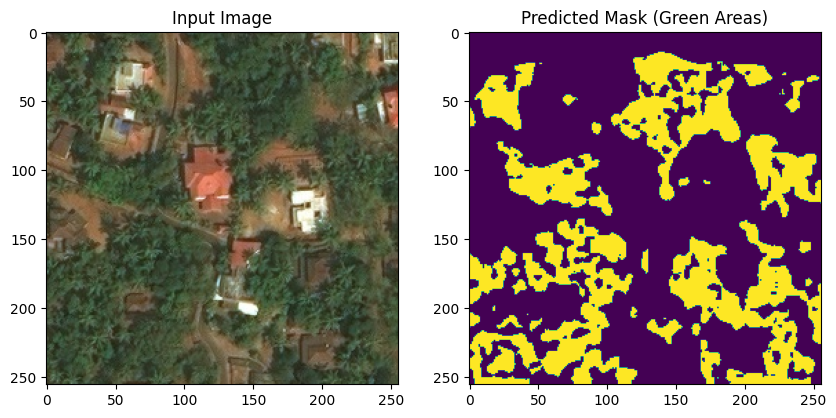

In [ ]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the trained model

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# Load the input image from your Google Drive
input_image_path = '/content/drive/MyDrive/images/3484_sat_61.jpg'  # Replace with your input image's file path
#input_image_path = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/Park all processed data/Preprocessed park/Geleb park-2010.jpg'  # Replace with your input image's file path
input_image = imread(input_image_path)[:, :, :3]  # Assuming 3 channels (RGB)
#input_image = resize(input_image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#input_image = input_image / 255.0  # Normalize the image

# Reshape the input image for prediction
input_image = np.expand_dims(input_image, axis=0)

# Predict green areas in the input image
predictions = ensemble_model1.predict(input_image)

#predicted_mask = (predictions > 0.8).astype(np.uint8)
predicted_mask = (predictions > 0.5).astype(np.uint8)

# Display the input image and the predicted mask (green areas)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(resize(predicted_mask[0, ..., 0], (input_image.shape[1], input_image.shape[2]), mode='constant'), cmap='viridis')
plt.title("Predicted Mask (Green Areas)")
plt.show()


In [ ]:
# Assuming you have these folders for test images and masks
test_image_folder = '/content/drive/MyDrive/customimages'
test_mask_folder = '/content/drive/MyDrive/custommasks'

# Prepare file names for the test generator
test_image_filenames = [fname for fname in os.listdir(test_image_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]  # Make sure to filter only image files
test_image_full_paths = [os.path.join(test_image_folder, fname) for fname in test_image_filenames]

# Create data generator for testing
test_gen = CustomDataGen(test_image_full_paths, test_mask_folder, BATCH_SIZE, IMAGE_SIZE)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
import numpy as np

# Assuming 'test_gen' is your test data generator
predictions = ensemble_model1.predict(test_gen)
thresholded_preds = (predictions > 0.5).astype(np.uint8)

# Assuming 'thresholded_preds' are your binary predictions

# Ensure binary format for true labels
# Example thresholding, adjust as necessary
binary_true_labels = (flat_true_labels > 0.5).astype(np.uint8)

# Flatten both predictions and true labels
flat_predictions = thresholded_preds.flatten()
flat_binary_true_labels = binary_true_labels.flatten()

# Calculate the metrics
accuracy = accuracy_score(flat_binary_true_labels, flat_predictions)
precision = precision_score(flat_binary_true_labels, flat_predictions)
f1 = f1_score(flat_binary_true_labels, flat_predictions)

print(f"Accuracy: {accuracy}, Precision: {precision}, F1-Score: {f1}")



173/173 [==============================] - 46s 266ms/step
Accuracy: 0.9214162379244399, Precision: 0.832658820846619, F1-Score: 0.6900927060191542


In [ ]:
new_model_name = 'allcustomdatasetmodels_ensemble.h5'
ensemble_model1.save('/content/drive/My Drive/' + new_model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**UNET + SEGNET**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 10
image_folder = '/content/drive/MyDrive/customimages'
mask_folder = '/content/drive/MyDrive/custommasks'
# Load your pre-trained models
unet_model = load_model('/content/drive/MyDrive/unetfinal_newcustom.h5')
segnet_model = load_model('/content/drive/MyDrive/segnet_newcustom.h5')
#dlv3_model = load_model('/content/drive/MyDrive/deeplabv3plus_newcustom.h5')
# Create an ensemble model
models = [unet_model, segnet_model]
model_input = Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model2 = Model(inputs=model_input, outputs=ensemble_output, name='ensemble2')
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_folder, batch_size, target_size):
        self.image_filenames = image_filenames
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Construct mask filenames based on image filenames
        batch_y = ['pp_' + os.path.basename(file_name)[:-4] + '_mask.jpg' for file_name in batch_x]
        batch_y = [os.path.join(self.mask_folder, mask_name) for mask_name in batch_y]

        return np.array([
            img_to_array(load_img(file_name, target_size=self.target_size)) for file_name in batch_x])/255., np.array([
            img_to_array(load_img(mask_file, color_mode="grayscale", target_size=self.target_size)) for mask_file in batch_y])/255.

    def get_all_labels(self):
        all_labels = []
        for i in range(self.__len__()):
            _, labels = self.__getitem__(i)
            for label in labels:
                all_labels.append(label)
        return np.array(all_labels)


# Prepare file names for the generator
image_filenames = [fname for fname in os.listdir(image_folder)]
image_full_paths = [os.path.join(image_folder, fname) for fname in image_filenames]

# Split dataset into training and validation
train_images, val_images = train_test_split(image_full_paths, test_size=0.1, random_state=42)

# Create data generators
train_gen = CustomDataGen(train_images, mask_folder, BATCH_SIZE, IMAGE_SIZE)
val_gen = CustomDataGen(val_images, mask_folder, BATCH_SIZE, IMAGE_SIZE)

In [ ]:
ensemble_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Consider using a segmentation-specific metric

ensemble_history2 = ensemble_model2.fit(train_gen, epochs=8, validation_data=val_gen)

Epoch 1/8
156/156 [==============================] - 2721s 17s/step - loss: 0.3218 - accuracy: 0.7615 - val_loss: 0.4427 - val_accuracy: 0.7695
Epoch 2/8
156/156 [==============================] - 115s 738ms/step - loss: 0.3057 - accuracy: 0.7615 - val_loss: 0.4407 - val_accuracy: 0.7695
Epoch 3/8
156/156 [==============================] - 119s 760ms/step - loss: 0.2946 - accuracy: 0.7615 - val_loss: 0.3546 - val_accuracy: 0.7695
Epoch 4/8
156/156 [==============================] - 119s 761ms/step - loss: 0.2864 - accuracy: 0.7615 - val_loss: 0.3064 - val_accuracy: 0.7695
Epoch 5/8
156/156 [==============================] - 119s 761ms/step - loss: 0.2797 - accuracy: 0.7615 - val_loss: 0.3220 - val_accuracy: 0.7695
Epoch 6/8
156/156 [==============================] - 117s 748ms/step - loss: 0.2762 - accuracy: 0.7615 - val_loss: 0.2719 - val_accuracy: 0.7695
Epoch 7/8
156/156 [==============================] - 117s 749ms/step - loss: 0.2733 - accuracy: 0.7615 - val_loss: 0.3976 - val_acc

In [ ]:
new_model_name = 'unetsegnetcustom_ensemble.h5'
ensemble_model2.save('/content/drive/My Drive/' + new_model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the trained model

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# Load the input image from your Google Drive
#input_image_path = '/content/drive/MyDrive/images/3484_sat_61.jpg'  # Replace with your input image's file path
input_image_path = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/Park all processed data/Preprocessed park/Geleb park-2005.jpg'  # Replace with your input image's file path
input_image = imread(input_image_path)[:, :, :3]  # Assuming 3 channels (RGB)
#input_image = resize(input_image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#input_image = input_image / 255.0  # Normalize the image

# Reshape the input image for prediction
input_image = np.expand_dims(input_image, axis=0)

# Predict green areas in the input image
predictions = ensemble_model2.predict(input_image)

# Threshold the predictions to obtain binary masks
#predicted_mask = (predictions > 0.8).astype(np.uint8)
predicted_mask = (predictions > 0.2).astype(np.uint8)

# Display the input image and the predicted mask (green areas)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(resize(predicted_mask[0, ..., 0], (input_image.shape[1], input_image.shape[2]), mode='constant'), cmap='viridis')
plt.title("Predicted Mask (Green Areas)")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Assuming you have already defined CustomDataGen and loaded your ensemble model

# Define a function to calculate F1 Score
def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Function to apply threshold to predictions
def threshold_predictions(preds, threshold=0.8):
    return (preds > threshold).astype(np.float32)

# Prepare your data generators
# ... (your code to prepare train_gen and val_gen)

# Define metrics
precision_metric = Precision()
recall_metric = Recall()
accuracy_metric = BinaryAccuracy()

# Threshold for predictions (can be adjusted)
threshold = 0.4

# Reset metrics
precision_metric.reset_states()
recall_metric.reset_states()
accuracy_metric.reset_states()

# Iterate over the validation generator
for i in range(len(val_gen)):
    x, y_true = val_gen[i]
    y_pred = ensemble_model2.predict(x)

    # Apply threshold
    y_pred_processed = threshold_predictions(y_pred, threshold=threshold)

    # Update metrics
    precision_metric.update_state(y_true, y_pred_processed)
    recall_metric.update_state(y_true, y_pred_processed)
    accuracy_metric.update_state(y_true, y_pred_processed)

# Calculate final values of the metrics
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
f1 = calculate_f1_score(precision, recall)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')


1/1 [==============================] - 0s 47ms/step
Accuracy: 0.7919919490814209, Precision: 0.7158620953559875, Recall: 0.6471568942070007, F1 Score: 0.6797779169748165


**UNET+DLV3PLUS**

---



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 10
image_folder = '/content/drive/MyDrive/customimages'
mask_folder = '/content/drive/MyDrive/custommasks'
# Load your pre-trained models
unet_model = load_model('/content/drive/MyDrive/unetfinal_newcustom.h5')
#segnet_model = load_model('/content/drive/MyDrive/segnet_newcustom.h5')
dlv3_model = load_model('/content/drive/MyDrive/deeplabv3plus_newcustom.h5')
# Create an ensemble model
models = [unet_model, dlv3_model]
model_input = Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model3 = Model(inputs=model_input, outputs=ensemble_output, name='ensemble3')
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_folder, batch_size, target_size):
        self.image_filenames = image_filenames
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Construct mask filenames based on image filenames
        batch_y = ['pp_' + os.path.basename(file_name)[:-4] + '_mask.jpg' for file_name in batch_x]
        batch_y = [os.path.join(self.mask_folder, mask_name) for mask_name in batch_y]

        return np.array([
            img_to_array(load_img(file_name, target_size=self.target_size)) for file_name in batch_x])/255., np.array([
            img_to_array(load_img(mask_file, color_mode="grayscale", target_size=self.target_size)) for mask_file in batch_y])/255.

    def get_all_labels(self):
        all_labels = []
        for i in range(self.__len__()):
            _, labels = self.__getitem__(i)
            for label in labels:
                all_labels.append(label)
        return np.array(all_labels)


# Prepare file names for the generator
image_filenames = [fname for fname in os.listdir(image_folder)]
image_full_paths = [os.path.join(image_folder, fname) for fname in image_filenames]

# Split dataset into training and validation
train_images, val_images = train_test_split(image_full_paths, test_size=0.1, random_state=42)

# Create data generators
train_gen = CustomDataGen(train_images, mask_folder, BATCH_SIZE, IMAGE_SIZE)
val_gen = CustomDataGen(val_images, mask_folder, BATCH_SIZE, IMAGE_SIZE)

In [ ]:
ensemble_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Consider using a segmentation-specific metric

ensemble_history3 = ensemble_model3.fit(train_gen, epochs=9, validation_data=val_gen)

Epoch 1/9
156/156 [==============================] - 126s 487ms/step - loss: 0.2245 - accuracy: 0.7622 - val_loss: 2.2125 - val_accuracy: 0.7695
Epoch 2/9
156/156 [==============================] - 65s 415ms/step - loss: 0.2123 - accuracy: 0.7615 - val_loss: 1.1657 - val_accuracy: 0.7695
Epoch 3/9
156/156 [==============================] - 65s 416ms/step - loss: 0.2094 - accuracy: 0.7615 - val_loss: 0.3965 - val_accuracy: 0.7695
Epoch 4/9
156/156 [==============================] - 65s 414ms/step - loss: 0.2086 - accuracy: 0.7615 - val_loss: 0.3482 - val_accuracy: 0.7695
Epoch 5/9
156/156 [==============================] - 65s 415ms/step - loss: 0.2070 - accuracy: 0.7615 - val_loss: 0.3161 - val_accuracy: 0.7695
Epoch 6/9
156/156 [==============================] - 65s 415ms/step - loss: 0.2014 - accuracy: 0.7615 - val_loss: 0.2519 - val_accuracy: 0.7695
Epoch 7/9
156/156 [==============================] - 65s 416ms/step - loss: 0.1991 - accuracy: 0.7615 - val_loss: 0.1951 - val_accuracy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 39ms/step


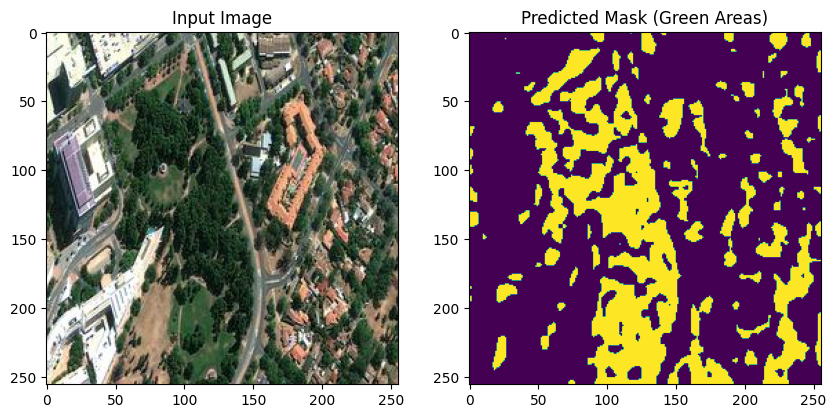

In [ ]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the trained model

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# Load the input image from your Google Drive
#input_image_path = '/content/drive/MyDrive/images/3484_sat_61.jpg'  # Replace with your input image's file path
input_image_path = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/Park all processed data/Preprocessed park/Geleb park-2005.jpg'  # Replace with your input image's file path
input_image = imread(input_image_path)[:, :, :3]  # Assuming 3 channels (RGB)
#input_image = resize(input_image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#input_image = input_image / 255.0  # Normalize the image

# Reshape the input image for prediction
input_image = np.expand_dims(input_image, axis=0)

# Predict green areas in the input image
predictions = ensemble_model3.predict(input_image)

# Threshold the predictions to obtain binary masks
#predicted_mask = (predictions > 0.8).astype(np.uint8)
predicted_mask = (predictions > 0.2).astype(np.uint8)

# Display the input image and the predicted mask (green areas)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(resize(predicted_mask[0, ..., 0], (input_image.shape[1], input_image.shape[2]), mode='constant'), cmap='viridis')
plt.title("Predicted Mask (Green Areas)")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Assuming you have already defined CustomDataGen and loaded your ensemble model

# Define a function to calculate F1 Score
def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Function to apply threshold to predictions
def threshold_predictions(preds, threshold=0.5):
    return (preds > threshold).astype(np.float32)

# Prepare your data generators
# ... (your code to prepare train_gen and val_gen)

# Define metrics
precision_metric = Precision()
recall_metric = Recall()
accuracy_metric = BinaryAccuracy()

# Threshold for predictions (can be adjusted)
threshold = 0.3

# Reset metrics
precision_metric.reset_states()
recall_metric.reset_states()
accuracy_metric.reset_states()

# Iterate over the validation generator
for i in range(len(val_gen)):
    x, y_true = val_gen[i]
    y_pred = ensemble_model3.predict(x)

    # Apply threshold
    y_pred_processed = threshold_predictions(y_pred, threshold=threshold)

    # Update metrics
    precision_metric.update_state(y_true, y_pred_processed)
    recall_metric.update_state(y_true, y_pred_processed)
    accuracy_metric.update_state(y_true, y_pred_processed)

# Calculate final values of the metrics
precision = precision_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
f1 = calculate_f1_score(precision, recall)

print(f'Accuracy: {accuracy}, Precision: {precision},  F1 Score: {f1}')


1/1 [==============================] - 0s 29ms/step
Accuracy: 0.829670786857605, Precision: 0.8849681615829468,  F1 Score: 0.5709360302665847


In [ ]:
new_model_name = 'unetdlv3custom_ensemble.h5'
ensemble_model3.save('/content/drive/My Drive/' + new_model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**SEGNET+DLV3**

---



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 10
image_folder = '/content/drive/MyDrive/customimages'
mask_folder = '/content/drive/MyDrive/custommasks'
# Load your pre-trained models
#unet_model = load_model('/content/drive/MyDrive/unetfinal_newcustom.h5')
segnet_model = load_model('/content/drive/MyDrive/segnet_newcustom.h5')
dlv3_model = load_model('/content/drive/MyDrive/deeplabv3plus_newcustom.h5')
# Create an ensemble model
models = [segnet_model, dlv3_model]
model_input = Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model4 = Model(inputs=model_input, outputs=ensemble_output, name='ensemble4')
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_folder, batch_size, target_size):
        self.image_filenames = image_filenames
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Construct mask filenames based on image filenames
        batch_y = ['pp_' + os.path.basename(file_name)[:-4] + '_mask.jpg' for file_name in batch_x]
        batch_y = [os.path.join(self.mask_folder, mask_name) for mask_name in batch_y]

        return np.array([
            img_to_array(load_img(file_name, target_size=self.target_size)) for file_name in batch_x])/255., np.array([
            img_to_array(load_img(mask_file, color_mode="grayscale", target_size=self.target_size)) for mask_file in batch_y])/255.

    def get_all_labels(self):
        all_labels = []
        for i in range(self.__len__()):
            _, labels = self.__getitem__(i)
            for label in labels:
                all_labels.append(label)
        return np.array(all_labels)


# Prepare file names for the generator
image_filenames = [fname for fname in os.listdir(image_folder)]
image_full_paths = [os.path.join(image_folder, fname) for fname in image_filenames]

# Split dataset into training and validation
train_images, val_images = train_test_split(image_full_paths, test_size=0.1, random_state=42)

# Create data generators
train_gen = CustomDataGen(train_images, mask_folder, BATCH_SIZE, IMAGE_SIZE)
val_gen = CustomDataGen(val_images, mask_folder, BATCH_SIZE, IMAGE_SIZE)

In [ ]:
ensemble_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Consider using a segmentation-specific metric

ensemble_history4 = ensemble_model4.fit(train_gen, epochs=9, validation_data=val_gen)

Epoch 1/9
156/156 [==============================] - 178s 817ms/step - loss: 0.2756 - accuracy: 0.8072 - val_loss: 0.4394 - val_accuracy: 0.7695
Epoch 2/9
156/156 [==============================] - 127s 816ms/step - loss: 0.2554 - accuracy: 0.8102 - val_loss: 0.4368 - val_accuracy: 0.7695
Epoch 3/9
156/156 [==============================] - 128s 821ms/step - loss: 0.2436 - accuracy: 0.8116 - val_loss: 0.3537 - val_accuracy: 0.7744
Epoch 4/9
156/156 [==============================] - 128s 820ms/step - loss: 0.2345 - accuracy: 0.8117 - val_loss: 0.3456 - val_accuracy: 0.7784
Epoch 5/9
156/156 [==============================] - 128s 821ms/step - loss: 0.2239 - accuracy: 0.8135 - val_loss: 0.2968 - val_accuracy: 0.7791
Epoch 6/9
156/156 [==============================] - 128s 820ms/step - loss: 0.2169 - accuracy: 0.8138 - val_loss: 0.2510 - val_accuracy: 0.7939
Epoch 7/9
156/156 [==============================] - 128s 821ms/step - loss: 0.2088 - accuracy: 0.8150 - val_loss: 0.3198 - val_ac

1/1 [==============================] - 0s 72ms/step


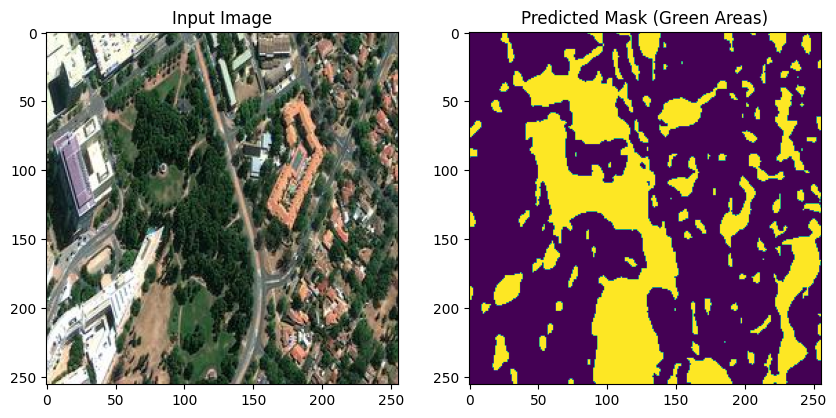

In [ ]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# Load the input image from your Google Drive
#input_image_path = '/content/drive/MyDrive/images/3484_sat_61.jpg'  # Replace with your input image's file path
input_image_path = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/Park all processed data/Preprocessed park/Geleb park-2005.jpg'  # Replace with your input image's file path
input_image = imread(input_image_path)[:, :, :3]  # Assuming 3 channels (RGB)
input_image = resize(input_image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
input_image = input_image / 255.0  # Normalize the image

# Reshape the input image for prediction
input_image = np.expand_dims(input_image, axis=0)

# Predict green areas in the input image
predictions = ensemble_model4.predict(input_image)

# Threshold the predictions to obtain binary masks
#predicted_mask = (predictions > 0.8).astype(np.uint8)
predicted_mask = (predictions > 0.4).astype(np.uint8)

# Display the input image and the predicted mask (green areas)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(resize(predicted_mask[0, ..., 0], (input_image.shape[1], input_image.shape[2]), mode='constant'), cmap='viridis')
plt.title("Predicted Mask (Green Areas)")
plt.show()


In [ ]:
new_model_name = 'segnetdlv3customlatest_ensemble.h5'
ensemble_model4.save('/content/drive/My Drive/' + new_model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_path = '/content/drive/MyDrive/segnetdlv3latestcustom_ensemble.h5'  # Replace with your model's file path
ensemble_model4 = load_model(model_path)

OSError: ignored

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Assuming you have already defined CustomDataGen and loaded your ensemble model

# Define a function to calculate F1 Score
def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Function to apply threshold to predictions
def threshold_predictions(preds, threshold=0.9):
    return (preds > threshold).astype(np.float32)

# Prepare your data generators
# ... (your code to prepare train_gen and val_gen)

# Define metrics
precision_metric = Precision()
recall_metric = Recall()
accuracy_metric = BinaryAccuracy()

# Threshold for predictions (can be adjusted)
threshold = 0.6

# Reset metrics
precision_metric.reset_states()
recall_metric.reset_states()
accuracy_metric.reset_states()

# Iterate over the validation generator
for i in range(len(val_gen)):
    x, y_true = val_gen[i]
    y_pred = ensemble_model4.predict(x)

    # Apply threshold
    y_pred_processed = threshold_predictions(y_pred, threshold=threshold)

    # Update metrics
    precision_metric.update_state(y_true, y_pred_processed)
    recall_metric.update_state(y_true, y_pred_processed)
    accuracy_metric.update_state(y_true, y_pred_processed)

# Calculate final values of the metrics
precision = precision_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
f1 = calculate_f1_score(precision, recall)

print(f'Accuracy: {accuracy}, Precision: {precision},  F1 Score: {f1}')


1/1 [==============================] - 0s 81ms/step
Accuracy: 0.8146448135375977, Precision: 0.9515703320503235,  F1 Score: 0.0


In [ ]:
import os
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Parameters
n_splits = 5  # Number of folds for K-Fold Validation
image_folder = '/content/drive/MyDrive/customimages''
mask_folder = '/content/drive/MyDrive/custommasks''
image_size = (256, 256)

# Load your best model
model = load_model('/content/drive/My Drive/allcustomdatasetmodels_ensemble.h5')

# Load images and masks
def load_data(image_folder, mask_folder):
    images = []
    masks = []
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename)  # Assuming mask and image files have same names

        img = load_img(img_path, target_size=image_size)
        mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')

        images.append(img_to_array(img))
        masks.append(img_to_array(mask))

    return np.array(images), np.array(masks)

images, masks = load_data(image_folder, mask_folder)

# Normalize data
images = images / 255.0
masks = masks / 255.0

# K-Fold Validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_index, test_index in kf.split(images):
    X_train, X_test = images[train_index], images[test_index]
    Y_train, Y_test = masks[train_index], masks[test_index]

    # Fit the model
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32)

    # Evaluate the model
    scores = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
